In [1]:
import cheetah
from typing import Dict, Optional
import torch
import torch.nn as nn
from xopt import Xopt, VOCS, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
# from xopt.generators.bayesian.models.prior_mean import CustomMean
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
def simple_fodo_problem(
    input_param: Dict[str, float], incoming_beam: Optional[cheetah.Beam] = None
) -> Dict[str, float]:
    if incoming_beam is None:
        incoming_beam = cheetah.ParameterBeam.from_parameters(
            sigma_x=torch.tensor(1e-4),
            sigma_y=torch.tensor(2e-3),
            sigma_xp=torch.tensor(1e-4),
            sigma_yp=torch.tensor(1e-4),
            energy=torch.tensor(100e6),
        )

    fodo_segment = cheetah.Segment(
        [
            cheetah.Quadrupole(
                length=0.1, k1=torch.tensor(input_param["q1"]), name="Q1"
            ),
            cheetah.Drift(length=0.5, name="D1"),
            cheetah.Quadrupole(
                length=0.1, k1=torch.tensor(input_param["q2"]), name="Q2"
            ),
            cheetah.Drift(length=0.5, name="D1"),
        ]
    )

    out_beam = fodo_segment(incoming_beam)

    beam_size_mse = torch.mean(out_beam.sigma_x**2 + out_beam.sigma_y**2)
    beam_size_mae = torch.mean(out_beam.sigma_x.abs() + out_beam.sigma_y.abs())
    return {
        "mse": beam_size_mse.detach().numpy(),
        # "bilog_mse": (beam_size_mse.sign() * (beam_size_mse.abs() + 1).log()).detach().numpy(),
        "log_mse": beam_size_mse.log().detach().numpy(),
        "mae": beam_size_mae.detach().numpy(),
        "log_mae": beam_size_mae.log().detach().numpy(),
    }

In [3]:
vocs_config = """ 
variables:
    q1: [-30, 15]
    q2: [-15, 30]
objectives:
    mae: minimize
"""

vocs = VOCS.from_yaml(vocs_config)
generator = UpperConfidenceBoundGenerator(beta=1.0, vocs=vocs)
evaluator = Evaluator(
    function=simple_fodo_problem, function_kwargs={"incoming_beam": None}
)

In [4]:
xopt = Xopt(
    vocs=vocs,
    generator=generator,
    evaluator=evaluator,
)

In [5]:
xopt.evaluate_data(
    {
        "q1": 0,
        "q2": 0,
    }
)
for i in range(10):
    xopt.step()

In [6]:
xopt.data

,q1,q2,mse,log_mse,mae,log_mae,xopt_runtime,xopt_error
0,0.000000,0.000000,4.0388004e-06,-12.419563,0.0021598018,-6.1377387,0.003237,False
1,-30.000000,30.000000,4.925818e-05,-9.918435,0.007041119,-4.955988,0.000677,False
2,9.703501,-13.189836,4.0646137e-06,-12.413192,0.0021715362,-6.1323204,0.000589,False
3,15.000000,2.535243,3.6908732e-05,-10.207063,0.006198688,-5.0834174,0.000593,False
4,-2.379825,-13.691026,1.17312595e-07,-15.958424,0.00047899887,-7.643812,0.000600,False
5,-11.556320,-10.917530,1.1227646e-06,-13.699717,0.0013684666,-6.594064,0.000650,False
6,-3.010797,-9.461003,2.9130018e-07,-15.048911,0.000729128,-7.2236614,0.000637,False
7,-4.905788,-15.000000,1.7511759e-07,-15.557808,0.0005895201,-7.4362016,0.000624,False
8,-0.176331,-15.000000,2.0391045e-07,-15.405585,0.00062808895,-7.372829,0.000595,False
9,-2.996418,-13.415012,1.0082165e-07,-16.109913,0.00042832235,-7.7556343,0.000602,False


In [7]:
xopt.generator.model.models[0].mean_module.constant

Parameter containing:
tensor(1.2892, dtype=torch.float64, requires_grad=True)

## Test Custom Prior Mean

In [8]:
from click import Option
from xopt.generators.bayesian.models.standard import StandardModelConstructor


class FodoPriorMean(nn.Module):
    def __init__(self, incoming_beam: Optional[cheetah.Beam] = None):
        super().__init__()
        if incoming_beam is None:
            incoming_beam = cheetah.ParameterBeam.from_parameters(
                sigma_x=torch.tensor(1e-4),
                sigma_y=torch.tensor(2e-3),
                sigma_xp=torch.tensor(1e-4),
                sigma_yp=torch.tensor(1e-4),
                energy=torch.tensor(100e6),
            )
        self.incoming_beam = incoming_beam
        self.segment = cheetah.Segment(
            [
                cheetah.Quadrupole(length=0.1, k1=torch.tensor(0.0), name="Q1"),
                cheetah.Drift(length=0.5, name="D1"),
                cheetah.Quadrupole(length=0.1, k1=torch.tensor(0.0), name="Q2"),
                cheetah.Drift(length=0.5, name="D1"),
            ]
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        input_shape = X.shape
        X = X.reshape(-1, 2)
        y_s = torch.zeros(X.shape[:-1])
        for i, input_values in enumerate(X):
            self.segment.elements[0].k1 = input_values[0].float()
            self.segment.elements[2].k1 = input_values[1].float()
            out_beam = self.segment(self.incoming_beam)
            beam_size_mae = torch.mean(out_beam.sigma_x.abs() + out_beam.sigma_y.abs())
            y_s[i] = beam_size_mae
        return y_s.reshape(input_shape[:-1])

In [29]:
gp_constructor = StandardModelConstructor(
    mean_modules={"mae":FodoPriorMean()}
)
generator_prior_mean = UpperConfidenceBoundGenerator(
    beta=1.0, vocs=vocs, gp_constructor=gp_constructor
)

xopt_prior_mean = Xopt(
    vocs=vocs,
    generator=generator_prior_mean,
    evaluator=evaluator,
)

Verifying model name='standard' use_low_noise_prior=True covar_modules={} mean_modules={'mae': FodoPriorMean(
  (incoming_beam): ParameterBeam(mu_x=tensor(0.), mu_xp=tensor(0.), mu_y=tensor(0.), mu_yp=tensor(0.), sigma_x=tensor(1.0000e-04), sigma_xp=tensor(1.0000e-04), sigma_y=tensor(0.0020), sigma_yp=tensor(1.0000e-04), sigma_s=tensor(1.0000e-06), sigma_p=tensor(1.0000e-06), energy=tensor(100000000.)), total_charge=tensor(0.))
  (segment): Segment(elements=ModuleList(
    (0): Quadrupole(length=0.1, k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='Q1', device="'cpu'")
    (1): Drift(length=0.5, name='D1', device='cpu')
    (2): Quadrupole(length=0.1, k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='Q2', device="'cpu'")
    (3): Drift(length=0.5, name='D1', device='cpu')
  ), name='unnamed', device='cpu')
)} trainable_mean_keys=[]


In [30]:
xopt_prior_mean.evaluate_data(
    {
        "q1": 0,
        "q2": 0,
    }
)
for i in range(10):
    xopt_prior_mean.step()

In [31]:
xopt_prior_mean.data

,q1,q2,mse,log_mse,mae,log_mae,xopt_runtime,xopt_error
0,0.000000,0.000000,4.0388004e-06,-12.419563,0.0021598018,-6.1377387,0.002938,False
1,-24.172925,30.000000,2.2030128e-05,-10.7231,0.0047147,-5.35707,0.000553,False
2,-12.273421,24.048014,4.0960202e-08,-17.010664,0.00024239883,-8.324926,0.000551,False
3,-12.319299,24.433301,4.1240067e-08,-17.003855,0.00024104114,-8.330543,0.000587,False
4,-12.493894,26.506315,4.339823e-08,-16.952847,0.00023722948,-8.346482,0.000529,False
5,-12.410131,25.526919,4.2273083e-08,-16.979115,0.00023818406,-8.342466,0.000529,False
6,-12.496631,26.540351,4.344093e-08,-16.951864,0.00023723325,-8.346467,0.000539,False
7,-12.389827,25.265586,4.200308e-08,-16.985523,0.00023872397,-8.340202,0.000538,False
8,-12.302009,24.332433,4.1171255e-08,-17.005526,0.00024139504,-8.329076,0.000527,False
9,-12.547434,27.091526,4.4167535e-08,-16.935276,0.00023771072,-8.344456,0.000591,False


In [43]:
# Test mismatch situation
mismatched_incoming_beam = cheetah.ParameterBeam.from_parameters(
            sigma_x=torch.tensor(1e-3),
            sigma_y=torch.tensor(1e-3),
            sigma_xp=torch.tensor(1e-4),
            sigma_yp=torch.tensor(1e-4),
            energy=torch.tensor(100e6),
        )
evaluator_different_beam = Evaluator(function=simple_fodo_problem, function_kwargs={"incoming_beam": mismatched_incoming_beam})

generator_prior_mean_mismatch = UpperConfidenceBoundGenerator(
    beta=1.0, vocs=vocs, gp_constructor=gp_constructor
)

xopt_prior_mean_mismatch = Xopt(
    vocs=vocs,
    generator=generator_prior_mean,
    evaluator=evaluator_different_beam,
)

xopt_prior_mean_mismatch.evaluate_data(
    {
        "q1": 0,
        "q2": 0,
    }
)
for i in tqdm(range(10)):
    xopt_prior_mean_mismatch.step()

Verifying model name='standard' use_low_noise_prior=True covar_modules={} mean_modules={'mae': FodoPriorMean(
  (incoming_beam): ParameterBeam(mu_x=tensor(0.), mu_xp=tensor(0.), mu_y=tensor(0.), mu_yp=tensor(0.), sigma_x=tensor(1.0000e-04), sigma_xp=tensor(1.0000e-04), sigma_y=tensor(0.0020), sigma_yp=tensor(1.0000e-04), sigma_s=tensor(1.0000e-06), sigma_p=tensor(1.0000e-06), energy=tensor(100000000.)), total_charge=tensor(0.))
  (segment): Segment(elements=ModuleList(
    (0): Quadrupole(length=0.1, k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='Q1', device="'cpu'")
    (1): Drift(length=0.5, name='D1', device='cpu')
    (2): Quadrupole(length=0.1, k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='Q2', device="'cpu'")
    (3): Drift(length=0.5, name='D1', device='cpu')
  ), name='unnamed', device='cpu')
)} trainable_mean_keys=[]


100%|██████████| 10/10 [04:45<00:00, 28.58s/it]


In [56]:
# Grid Scan for best point
xs = np.linspace(-30, 15, 150)
ys = np.linspace(-15, 30, 150)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        Z[i, j] = simple_fodo_problem(
            {
                "q1": float(x),
                "q2": float(y),
            })["log_mae"]
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
mismatched_best = simple_fodo_problem({
    "q1": float(X[min_idx]),
    "q2": float(Y[min_idx]),
}, incoming_beam=mismatched_incoming_beam)
print(min_idx, Z[min_idx])
print(X[min_idx], Y[min_idx])
print(mismatched_best)

(58, 137) -8.346435546875
11.375838926174495 2.5167785234899327
{'mse': array(6.7325823e-06, dtype=float32), 'log_mse': array(-11.908552, dtype=float32), 'mae': array(0.00291766, dtype=float32), 'log_mae': array(-5.836973, dtype=float32)}


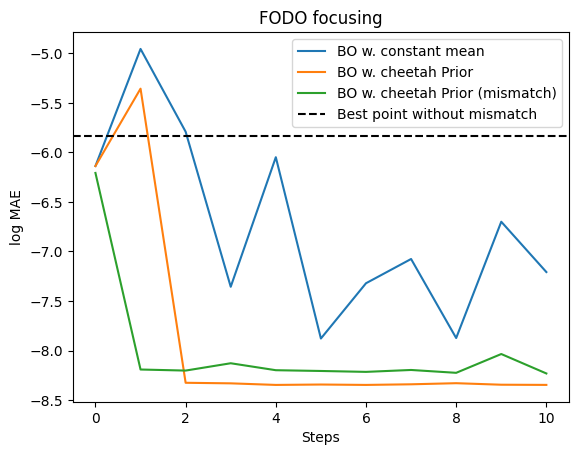

In [57]:
plt.plot(xopt.data["log_mae"], label='BO w. constant mean')
plt.plot(xopt_prior_mean.data["log_mae"], label='BO w. cheetah Prior')
plt.plot(xopt_prior_mean_mismatch.data["log_mae"], label='BO w. cheetah Prior (mismatch)')
plt.axhline(mismatched_best["log_mae"], label='Best point without mismatch', ls='--', c='k')
plt.legend()
plt.xlabel("Steps")
plt.ylabel("log MAE")
plt.title("FODO focusing")
plt.savefig("fodo_example.png")

In [45]:
xopt_prior_mean_mismatch.data

,q1,q2,mse,log_mse,mae,log_mae,xopt_runtime,xopt_error
0,0.000000,0.000000,2.0288005e-06,-13.108066,0.0020143487,-6.2074594,0.000741,False
1,-12.437743,25.766152,4.678785e-08,-16.877642,0.00027713293,-8.191013,0.000453,False
2,-12.421261,25.798604,4.6399784e-08,-16.885971,0.0002741689,-8.201766,0.000478,False
3,-12.401352,25.522639,4.959901e-08,-16.819296,0.0002952183,-8.127795,0.000458,False
4,-12.423331,25.785834,4.653164e-08,-16.883133,0.000275199,-8.198016,0.000447,False
5,-12.426507,25.814814,4.625901e-08,-16.88901,0.00027308072,-8.205743,0.000466,False
6,-12.428142,25.848138,4.595509e-08,-16.895601,0.00027061236,-8.214823,0.000483,False
7,-12.406258,25.771174,4.6634174e-08,-16.880932,0.00027587026,-8.19558,0.000535,False
8,-12.420789,25.880175,4.5660627e-08,-16.902029,0.00026803947,-8.224377,0.000473,False
9,-12.323074,25.140862,5.5606865e-08,-16.70496,0.00032401562,-8.0347185,0.000708,False


(39, 87)
9.545454545454547 2.7272727272727266


(39, 87) -8.327275276184082
9.545454545454547 2.7272727272727266
{'mse': array(5.5870205e-06, dtype=float32), 'log_mse': array(-12.095064, dtype=float32), 'mae': array(0.00253689, dtype=float32), 'log_mae': array(-5.976816, dtype=float32)}


In [10]:
segment_mean_module = FodoPriorMean()

%time segment_mean_module(torch.tensor([[0.0, 0.0]]))

CPU times: user 1.65 ms, sys: 389 µs, total: 2.04 ms
Wall time: 2.11 ms


tensor([0.0022])

In [14]:
for i in np.logspace(0,4,5):
    print("i", i)
    %time segment_mean_module(torch.zeros(int(i), 2))

i 1.0
CPU times: user 1.55 ms, sys: 1.06 ms, total: 2.61 ms
Wall time: 1.85 ms
i 10.0
CPU times: user 4.6 ms, sys: 14 µs, total: 4.61 ms
Wall time: 4.65 ms
i 100.0
CPU times: user 38.6 ms, sys: 266 µs, total: 38.9 ms
Wall time: 39.4 ms
i 1000.0
CPU times: user 335 ms, sys: 1.22 ms, total: 336 ms
Wall time: 347 ms
i 10000.0
CPU times: user 3.23 s, sys: 15.6 ms, total: 3.25 s
Wall time: 3.26 s
